Check suspicious cases eg PRAD: it seems mutational, but there are patients with lots of switches.

In [1]:
source("../data/env/variables.R")
source("~/wisdom/r/data_analysis_environment.R")
source("~/wisdom/r/clean_theme.R")
library(ggrepel)
library(RColorBrewer)
library(scales)
options(repr.plot.width=8, repr.plot.height=8)

# read switches
switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    subset(IsFunctional==1 & NotNoise==1 & IsModel==1 & Origin=="Tumor")
switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1 & IsFunctional==1 & Origin=="Tumor")

# read ME with top drivers
me <- lapply(1:10, function(i){
  read_tsv(paste0("../data/mutations/pannegative_mutual_exclusion.top_",i,"_drivers.txt")) %>%
    mutate(NumDrivers = i, Total = M + MS + S + N,
           M.p = M/Total, MS.p = MS/Total, 
           S.p = S/Total, N.p = N/Total,
           SwitchSamples = S + MS)
  }) %>% do.call("rbind",.)

# drivers mutations
mutatedDrivers <- read_tsv("../data/mutations/driver_mutation_number.txt") %>%
    mutate(PatientNumber = unlist(lapply(strsplit(as.character(Samples),","),length)),
           Rank=as.numeric(do.call("c",by(-PatientNumber,Tumor,rank))))

# read mutations
mutations <- read_tsv("../data/mutations/wes_mutations.txt")

# read mutual exclusion with specific drivers
me.specificDrivers <- read_tsv("../data/mutations/mutual_exclusion_top_drivers.txt") %>%
    mutate(Total = M + MS + S + N, M.p = M/Total, MS.p = MS/Total,
           S.p = S/Total, N.p = N/Total)

## read specific drivers
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
  mutate(Tumor_type = ifelse(Tumor_type=="COREAD", "coad", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="HC", "lihc", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="RCCC", "kirc", Tumor_type),
         Tumor_type = tolower(Tumor_type) ) %>%
  set_colnames(c("Symbol","Tumor"))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘scales’

The following objects are masked from ‘package:readr’:

    col_factor, col_numeric



# Aggregated data

Warning message:
: replacing previous import by ‘scales::alpha’ when loading ‘UpSetR’

[1] 1729

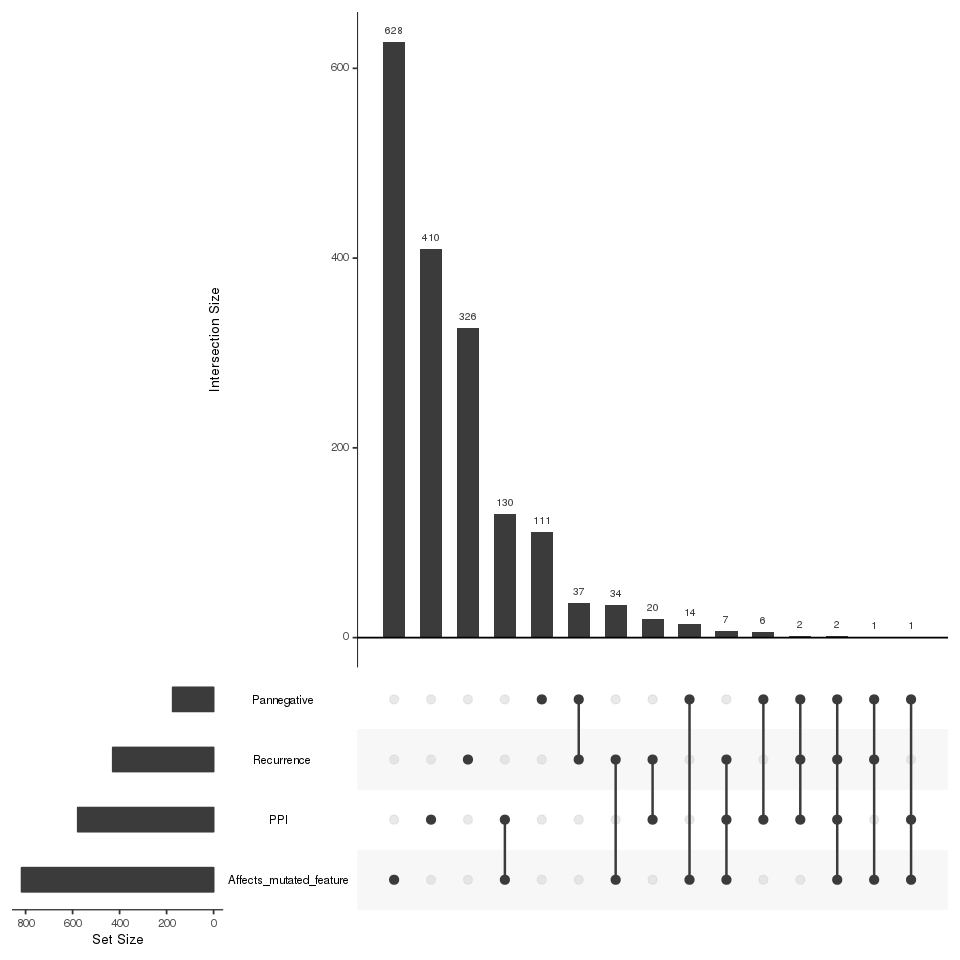

In [2]:
library(UpSetR)

potus <- switches %>%
    filter(Candidate==1) %>%
    select(GeneId,Symbol,Normal_transcript,Tumor_transcript)

nrow(potus)

switches %>%
    filter(Candidate==1) %>%
    select(Recurrence,Affects_mutated_feature,PPI,Pannegative) %>%
    mutate(Pannegative = ifelse(Pannegative > 2, 1,0)) %>%
    as.data.frame %>%
    upset(order.by = "freq", nintersects = 15)

# Tumor-specific

In [3]:
potus %>%
    merge(switches.split) %>%
    group_by(Tumor) %>%
    summarise(Recurrence = sum(Recurrence), Pannegative = sum(Pannegative > 0),
              Affects_mutated_feature = sum(Affects_mutated_feature), PPI = sum(PPI))

,Tumor,Recurrence,Pannegative,Affects_mutated_feature,PPI
1,brca,186,49,110,58
2,coad,106,2,74,51
3,hnsc,222,5,184,145
4,kich,219,9,186,140
5,kirc,257,27,173,131
6,kirp,302,37,310,238
7,lihc,58,10,39,34
8,luad,198,17,99,62
9,lusc,164,1,136,79
10,prad,162,16,104,92


In [4]:
# check that all the patients have at least one switch/mutation
alterationsPerPatient <- lapply(cancerTypes, function(tumor){
  
    # read switches
    tumor.potus <- switches.split %>%
        filter(Tumor==tumor) %>%
        merge(potus)
  
    ## count number of AS drivers switched per patient
    patients <- tumor.potus$Patients_affected %>% strsplit(",") %>% unlist
    switchesPerPatient <- plyr::count(patients) %>%
        set_colnames(c("Patient","Switches"))
  
    # read mutations  
    ## get cancer specific drivers
    tumor.drivers <- drivers$Symbol[drivers$Tumor==tumor]
   
    ## filter out mutations not in drivers
    mutations.drivers <- mutations %>%
        filter(Tumor == tumor) %>%
        filter(Symbol %in% tumor.drivers) %>%
        ## consider only mutated genes, not several mutations in a gene
        select(GeneId,Patient) %>%
        unique
    
    ## count number of mutations per patient
    mutationsPerPatient <- plyr::count(mutations.drivers$Patient) %>%
        set_colnames(c("Patient","Mutations"))
    
    # get patients with both RNAseq and mutation information
    patients.swt <- unique(patients)
    patients.mut <- unique(mutations$Patient)
    patients.common <- intersect(patients.swt,patients.mut)
    
    merge(mutationsPerPatient,switchesPerPatient, all=T) %>%
        mutate(Switches = ifelse(is.na(Switches), 0, Switches/nrow(tumor.potus) ),
               Mutations = ifelse(is.na(Mutations), 0, Mutations/length(tumor.drivers)),
               Tumor = tumor,
               Class = ifelse(Mutations < Switches, "S", "M")) %>%
        filter(Patient %in% patients.common)
  
}) %>% do.call("rbind",.)

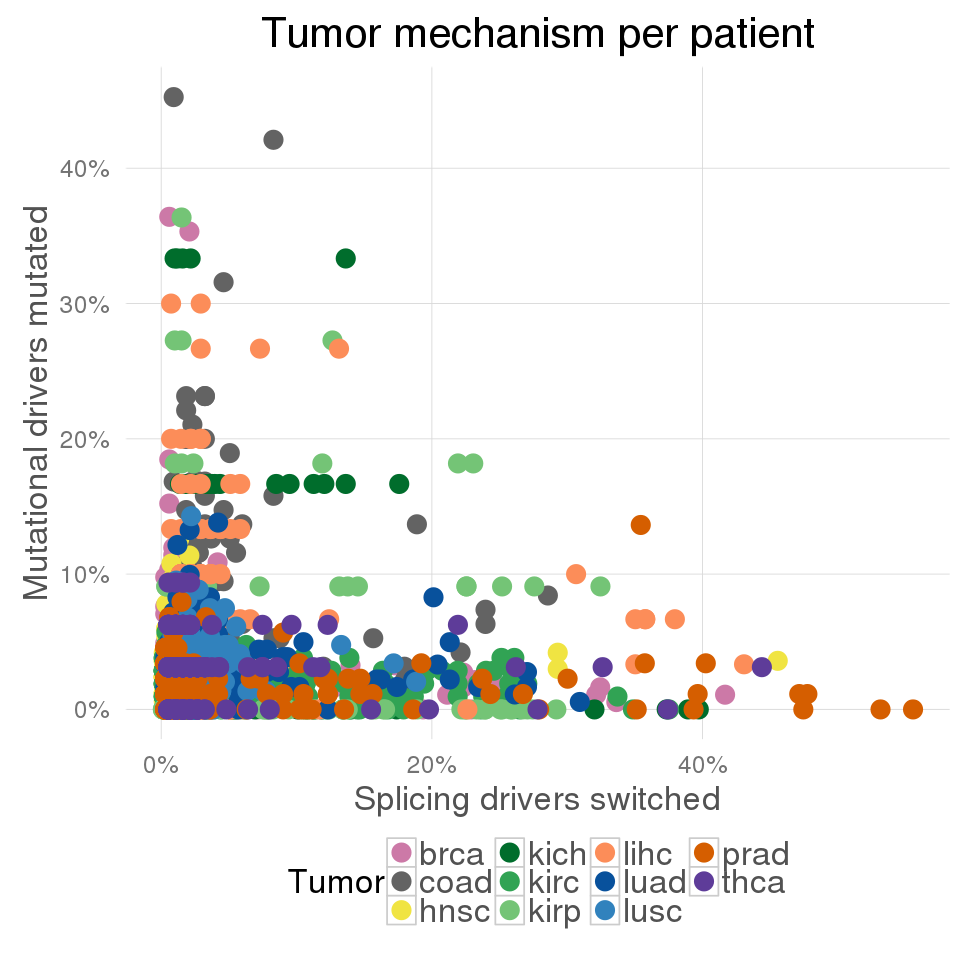

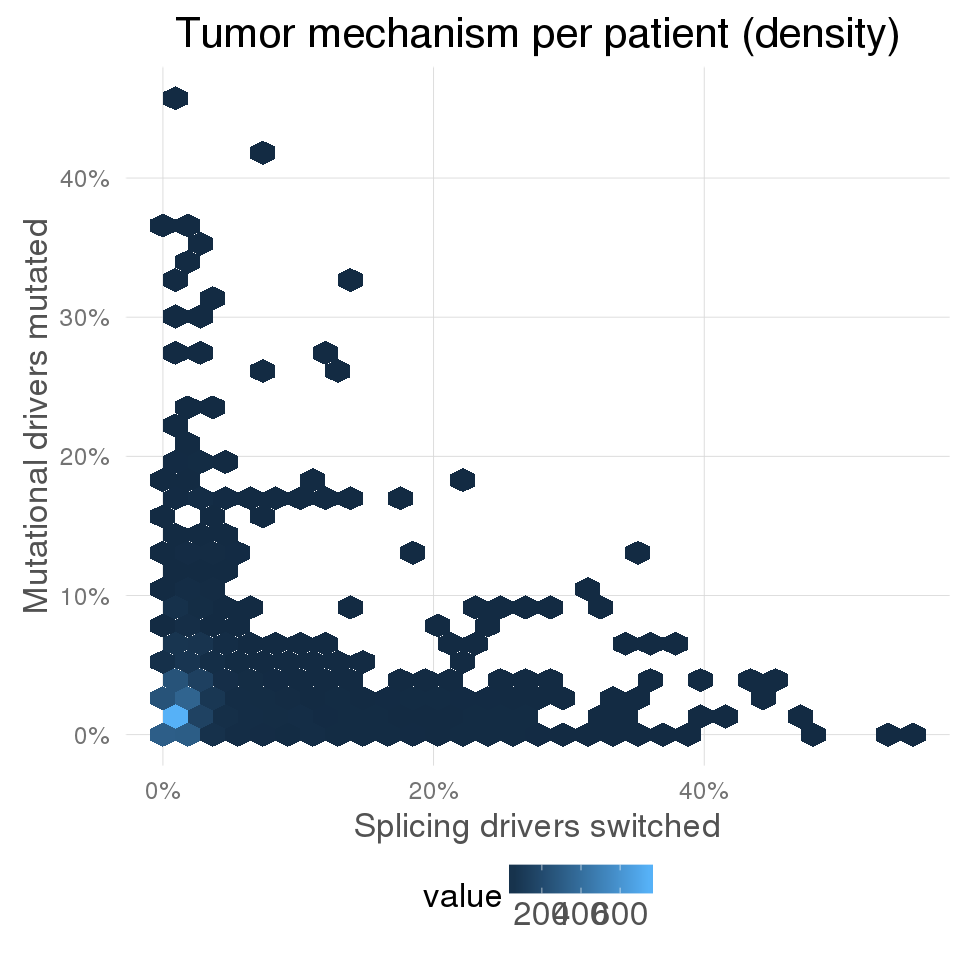

In [5]:
# plot raw frequency
ggplot(alterationsPerPatient,aes(x=Switches,y=Mutations,color=Tumor)) + 
    geom_point(size=5) + 
    clean_theme() +
    labs(x="Splicing drivers switched",y="Mutational drivers mutated", title="Tumor mechanism per patient") +
    scale_color_manual(values=colorPalette) +
    theme(legend.position="bottom") +
    scale_y_continuous(labels = percent) +
    scale_x_continuous(labels = percent)

# plot 2d density
rf <- colorRampPalette(rev(brewer.pal(11,'Spectral')))
ggplot(alterationsPerPatient,aes(x=Switches,y=Mutations)) + 
    stat_binhex() +
    clean_theme() +
    labs(x="Splicing drivers switched",y="Mutational drivers mutated", title="Tumor mechanism per patient (density)") +
    theme(legend.position="bottom") +
    scale_y_continuous(labels = percent) +
    scale_x_continuous(labels = percent)

Warning message:
: Stacking not well defined when ymin != 0

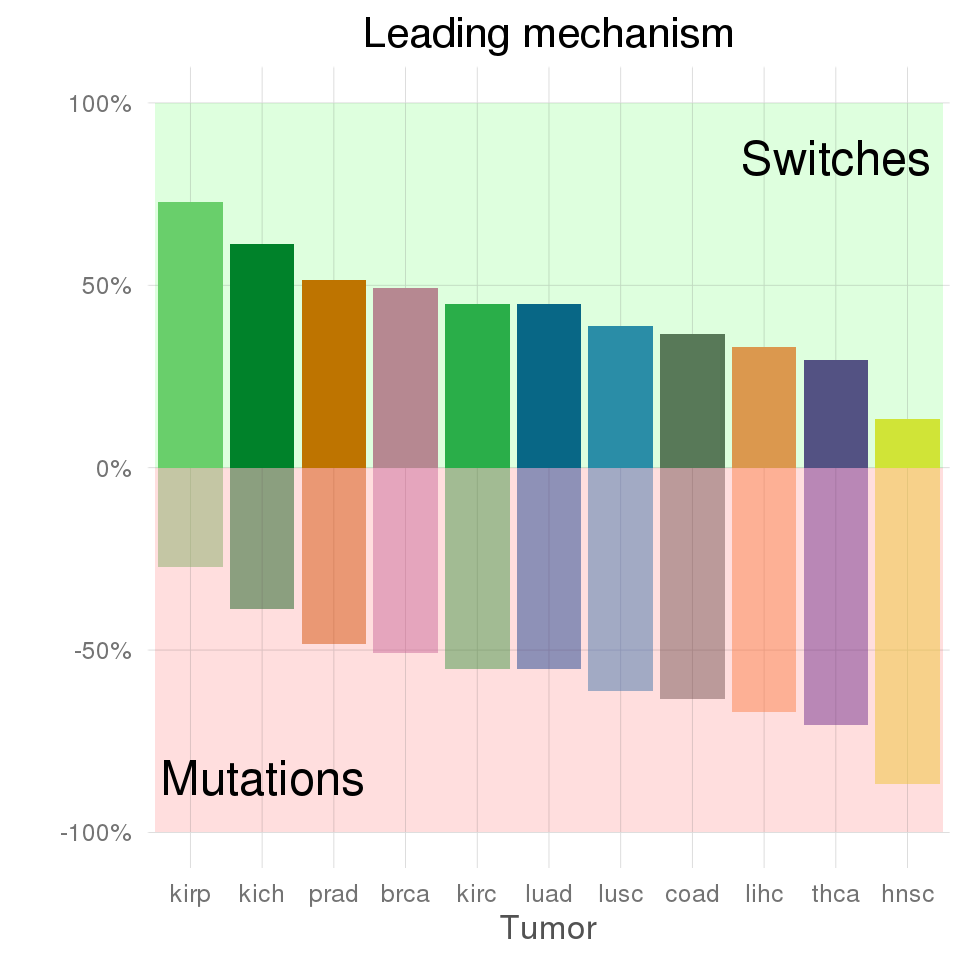

In [6]:
total <- alterationsPerPatient %>%
    plyr::count('Tumor') %>% 
    set_colnames(c("Tumor","Patients"))

tumorClassification <- alterationsPerPatient %>%
    plyr::count(c('Class','Tumor')) %>%
    set_colnames(c("Class","Tumor","Counts")) %>%
    merge(total) %>%
    mutate(Prop = Counts/Patients, Class = factor(Class, levels=c("S","M")),
           Tumor = factor(Tumor, levels=Tumor[Class=="S"][order(-Prop[Class=="S"])]))

ggplot() + 
    geom_bar(data = subset(tumorClassification, Class=="S"),aes(x=Tumor,y=Prop,fill=Tumor),stat="identity") +
    geom_bar(data = subset(tumorClassification, Class=="M"),aes(x=Tumor,y=-Prop,fill=Tumor),stat="identity",alpha=0.5) +
    geom_rect(data = subset(tumorClassification, Class=="M"), aes(xmin=0.5, xmax=11.5, ymin=0, ymax=1), 
              fill = "green", alpha = 0.01) +
    geom_rect(data = subset(tumorClassification, Class=="S"), aes(xmin=0.5, xmax=11.5, ymin=0, ymax=-1), 
              fill = "red", alpha = 0.01) +
    geom_text(aes(x=10,y=.85,label="Switches"), size=10) +
    geom_text(aes(x=2,y=-.85,label="Mutations"), size=10) +
    scale_fill_manual(values=colorPalette) +
    labs(y="",title="Leading mechanism") +
    scale_y_continuous(labels = percent) +
    clean_theme()

# Category split
## [PPI](../structural_analysis/ppi.ipynb)
## Pan-negative

Study switches that (a) are mutually exclusive with at least the 3 most frequent drivers in a tumor type and (b) present a pattern of mutual exclusion with a driver located in the same pathway.

### Pan-negative

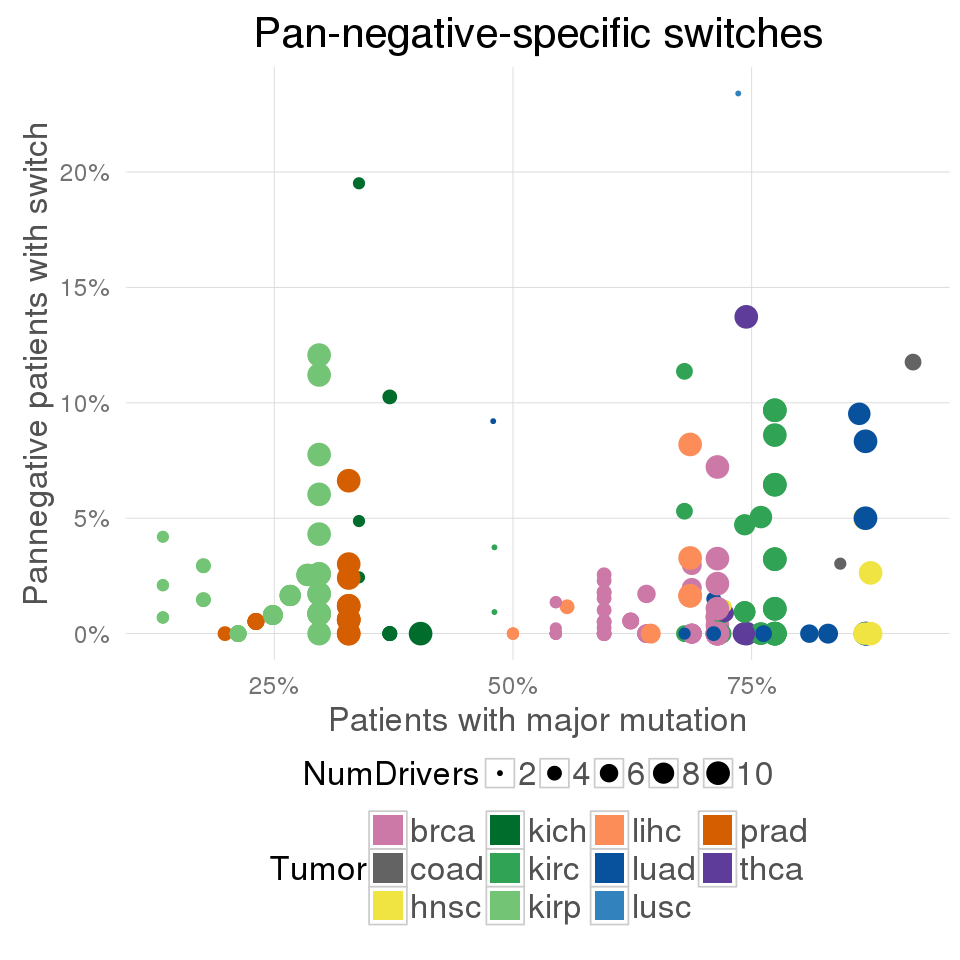

In [7]:
potus.pn <- switches %>%
    filter(Candidate==1 & Pannegative > 0 & Origin=="Tumor") %>%
    merge(me) %>%
    filter(p.me < 0.05) %>%
    by(., paste0(.$GeneId,.$Tumor), 
         function(X) X[which.max(X$NumDrivers),]) %>%
    do.call("rbind",.)
             
ggplot(potus.pn, aes(x = M.p+MS.p, y = S/(N+S), color = Tumor)) + 
    geom_point(aes(size = NumDrivers)) + 
#     geom_text_repel(aes(label=Symbol)) +
    clean_theme() +
    scale_color_manual(values=colorPalette) +
    labs(x="Patients with major mutation", y="Pannegative patients with switch",title="Pan-negative-specific switches") +
    theme(legend.position="bottom") +
    guides(col = guide_legend(override.aes = list(shape = 15, size = 8))) +
    scale_y_continuous(labels = percent) +
    scale_x_continuous(labels = percent)

The previous plot misses one dimension: the overlap between switches and mutations.

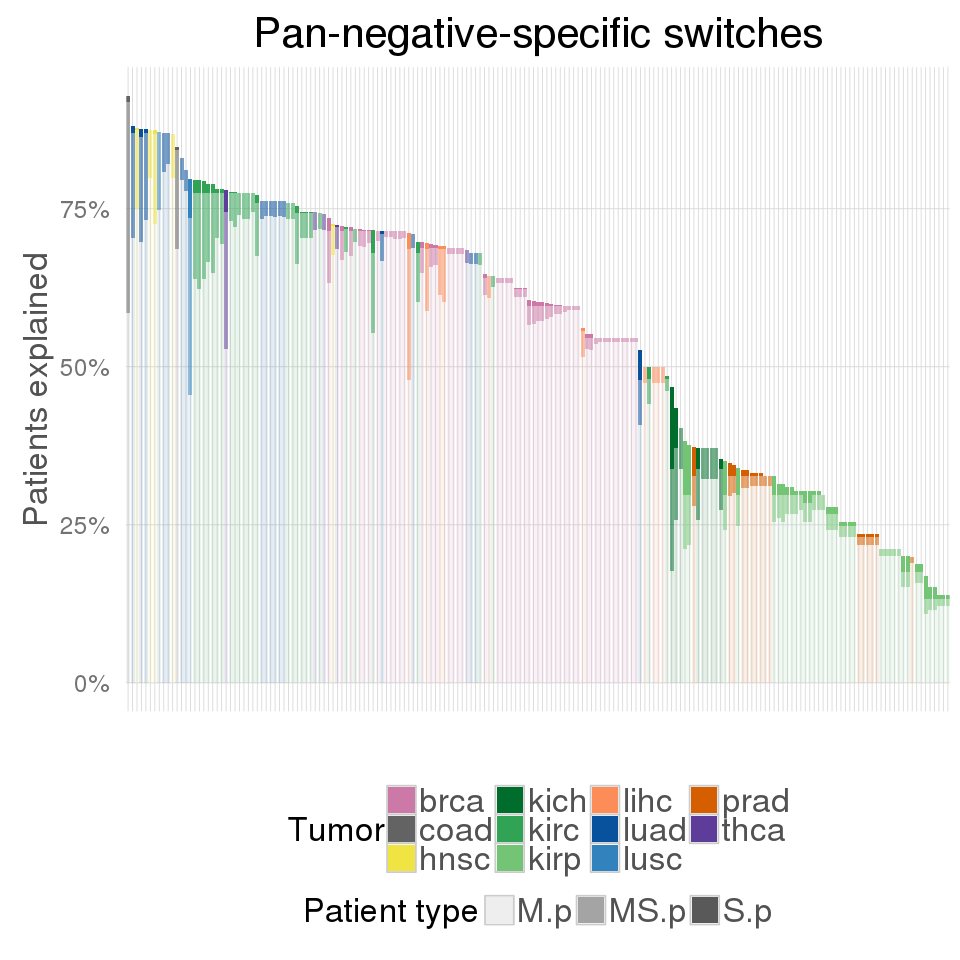

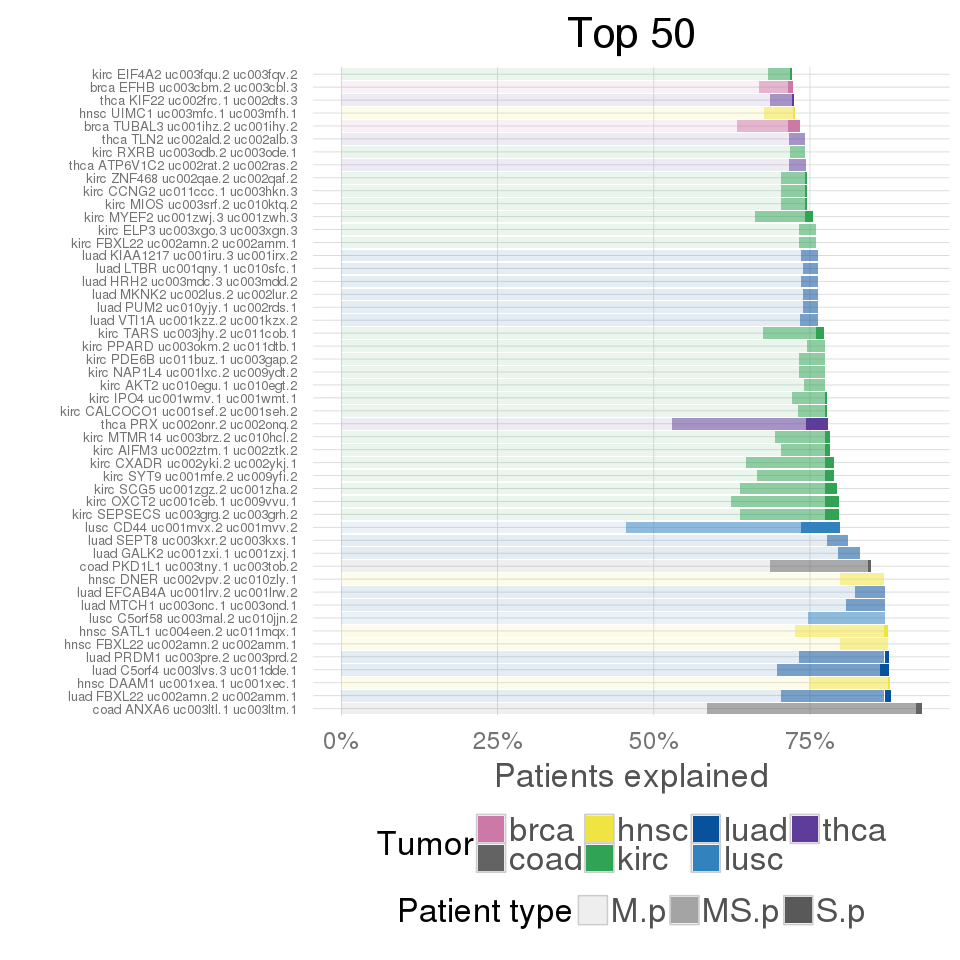

In [8]:
# prepare data
## order genes by total number of patients explained
df <- potus.pn %>%
    select(Tumor,GeneId,Symbol,Normal_transcript,Tumor_transcript,MS.p,M.p,S.p) %>%
    mutate(Switch = as.character(paste(Tumor,Symbol,Normal_transcript,Tumor_transcript))) %>%
    arrange(-(MS.p+M.p+S.p)) %>%
    mutate(Switch = factor(Switch,levels=Switch)) %>%
    select(Tumor,Switch,M.p,MS.p,S.p)

# overview of cases
melt(df, id.vars=c('Tumor','Switch')) %>%
    mutate(variable = factor(variable,levels=c("M.p","MS.p","S.p"))) %>%
    ggplot(aes(x=Switch,y=value, alpha=variable, fill=Tumor)) +
        geom_bar(stat="identity") +
        labs(x="", y="Patients explained", alpha="Patient type",title="Pan-negative-specific switches") +
        scale_fill_manual(values=colorPalette) +
        clean_theme() +
        theme(axis.text.x=element_blank(), legend.position="bottom") +
        scale_y_continuous(labels = percent)

# show in detail the cases where more patients are explained
melt(df[1:50,], id.vars=c('Tumor','Switch')) %>%
    mutate(variable = factor(variable,levels=c("M.p","MS.p","S.p"))) %>%
    ggplot(aes(x=Switch,y=value, alpha=variable, fill=Tumor)) +
        geom_bar(stat="identity") +
        labs(x="", y="Patients explained", alpha="Patient type",title="Top 50") +
        scale_fill_manual(values=colorPalette) +
        clean_theme() +
        theme(legend.position="bottom", axis.text.y=element_text(size=8)) +
        scale_y_continuous(labels = percent) +
        coord_flip()

### Mutational drivers

,Tumor,Symbol,DriverSymbol,Pathway
1,kirp,COL9A3,MET,"DEVELOPMENTAL BIOLOGY, AXON GUIDANCE, SYNDECAN 1 PATHWAY"
2,brca,CRKL,TP53,"NEUROTROPHIN SIGNALING PATHWAY, CHRONIC MYELOID LEUKEMIA, MAPK SIGNALING PATHWAY, PATHWAYS IN CANCER"
3,luad,CXADR,TP53,HEMOSTASIS
4,hnsc,DAAM1,TP53,WNT SIGNALING PATHWAY
5,hnsc,PPP1R13B,CDKN2A,"SIG PIP3 SIGNALING IN B LYMPHOCYTES,SIG PIP3 SIGNALING IN CARDIAC MYOCTES,ST PHOSPHOINOSITIDE 3 KINASE PATHWAY"
6,brca,PPP1R13B,TP53,P53DOWNSTREAMPATHWAY
7,luad,MKNK2,TP53,MAPK SIGNALING PATHWAY
8,brca,KIF3C,GATA3,"HEMOSTASIS, FACTORS INVOLVED IN MEGAKARYOCYTE DEVELOPMENT AND PLATELET PRODUCTION"
9,brca,ECSIT,TP53,MAPK SIGNALING PATHWAY
10,brca,RAB5A,TP53,"HEMOSTASIS, AMYOTROPHIC LATERAL SCLEROSIS ALS, FACTORS INVOLVED IN MEGAKARYOCYTE DEVELOPMENT AND PLATELET PRODUCTION, P38ALPHABETADOWNSTREAMPATHWAY"


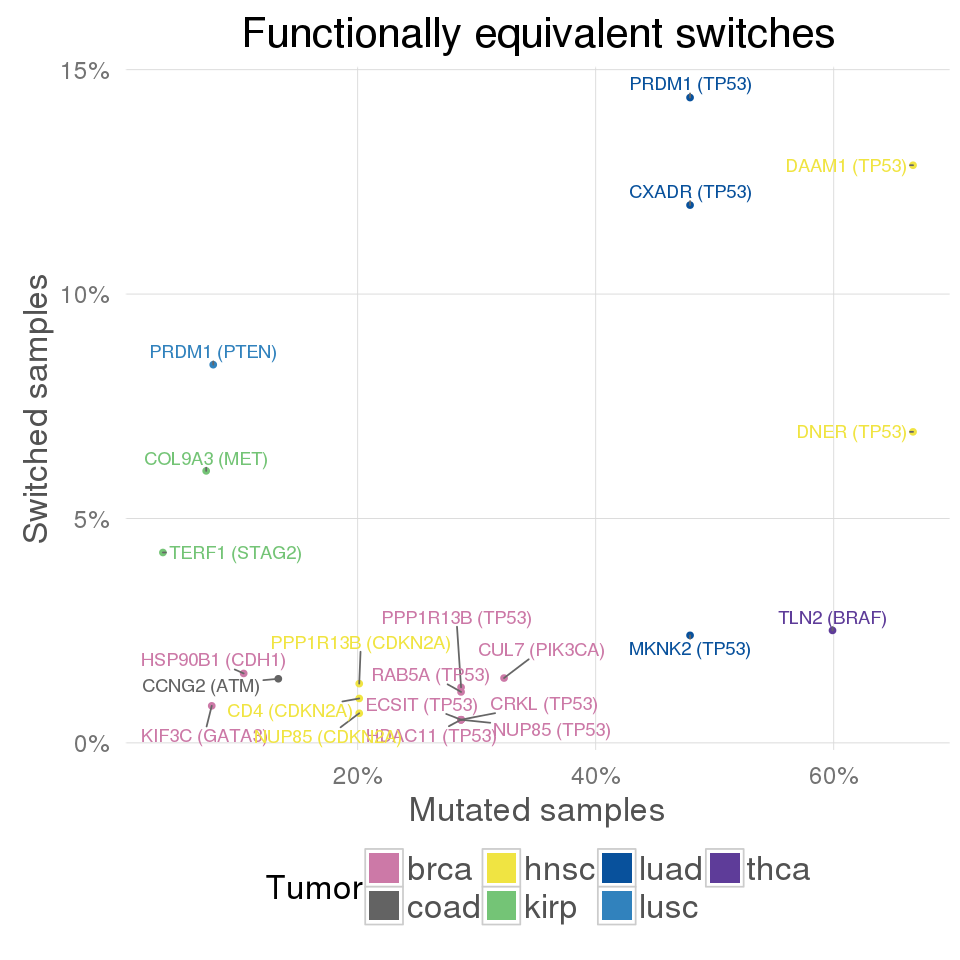

In [9]:
potus.d <- switches %>%
    filter(Candidate==1 & Pannegative > 0 & Origin=="Tumor") %>%
    merge(me.specificDrivers, by=c("GeneId","Symbol","Normal_transcript","Tumor_transcript")) %>%
    filter(p.me < 0.05 & Pathway!="")

potus.d %>%
    select(Tumor, Symbol, DriverSymbol, Pathway) %>%
    mutate(Pathway = gsub("_"," ",Pathway),
           Pathway = gsub("KEGG|REACTOME|PID","",Pathway))

ggplot(potus.d, aes(x = MS.p+M.p, y = MS.p+S.p, color = Tumor)) + 
    geom_point() +
    geom_text_repel(aes(label=paste0(Symbol," (",DriverSymbol,")"))) +
    labs(x="Mutated samples", y="Switched samples", title="Functionally equivalent switches") +
    scale_color_manual(values=colorPalette) +
    clean_theme() +
    theme(legend.position="bottom") +
    guides(col = guide_legend(override.aes = list(shape = 15, size = 8))) +
    scale_y_continuous(labels = percent) +
    scale_x_continuous(labels = percent)